# Gaussian Process

In [1]:
# Cusp Functions
from CUSP_functions import generate_featureset
from CUSP_functions import evaluator

In [2]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
# from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ConstantKernel

## Best Model

Dataset: D
Accuracy LC20%: 40.1%


This run includes spatial adjaceny features which increased the accuracy from ~38% to 40%. The model can be further hyper-tuned using gridsearch for optimzing the kernel(s). Based on the observation vs prediction graph the kernal is not catching outliers +1 fatality case most often. This points to potentially the noise parameter could be tuned to capture these observations.


### Load data

In [89]:
#generate dataset
data = generate_featureset('D', 'rank', 'csv', scale = 'normalize', roll_avg = True, 
                    pca = False, shift = True, train_periods = [20162, 20171, 20172, 20181, 20182, 20191, 20192],
                   test_periods = [20201], ties = 'min', geo = True, spatial = 'no_ACS')

dataset_v4_0729_164234_D_rank_norm__roll_shift_min.csv
total_features: 141


## Create Training and Test sets

In [96]:
# target variable
y_target_var = 'overdose_rank'
num_cbgs = len(data['geoid'].unique())

# training year(s)
train_years = [20162, 20171, 20172, 20181, 20182, 20191, 20192]

# testing year(s)
test_years = [20201]

# dropping non feature columns
drop_columns = ['overdose_rank', 'full_period','geoid', 'label', 'overdose_rank_t-1', 'neighbor_overdose_rank_t-1']

print("number of features: ",len(data.columns))

train = data[data.full_period.isin(train_years)]
print('training years:', sorted(set(train.full_period.values)))

print("----------")

test = data[data.full_period.isin(test_years)]
print('testing year(s):', sorted(set(test.full_period.values)))

print("testing shape: ",test.shape)

# create training split based on year(s)
x_train = train.drop(columns=drop_columns)
y_train = train[y_target_var]

# create testing split based on year(s)
x_test = test.drop(columns=drop_columns)
y_test = test[y_target_var]

print("-------")
print('x_train', x_train.shape)
print('x_test', x_test.shape)

number of features:  145
training years: [20162, 20171, 20172, 20181, 20182, 20191, 20192]
----------
testing year(s): [20201]
testing shape:  (811, 145)
-------
x_train (5677, 139)
x_test (811, 139)


### Run Model

fit and predict and visualize the model run.

Takes ~1.5hrs

best kernel found during restarts:  RBF(length_scale=34.5) + WhiteKernel(noise_level=0.938) + RationalQuadratic(alpha=1.05, length_scale=6.37)
marginal likelehood:  -7929.491131762192
R2 score:  0.05275242961386106


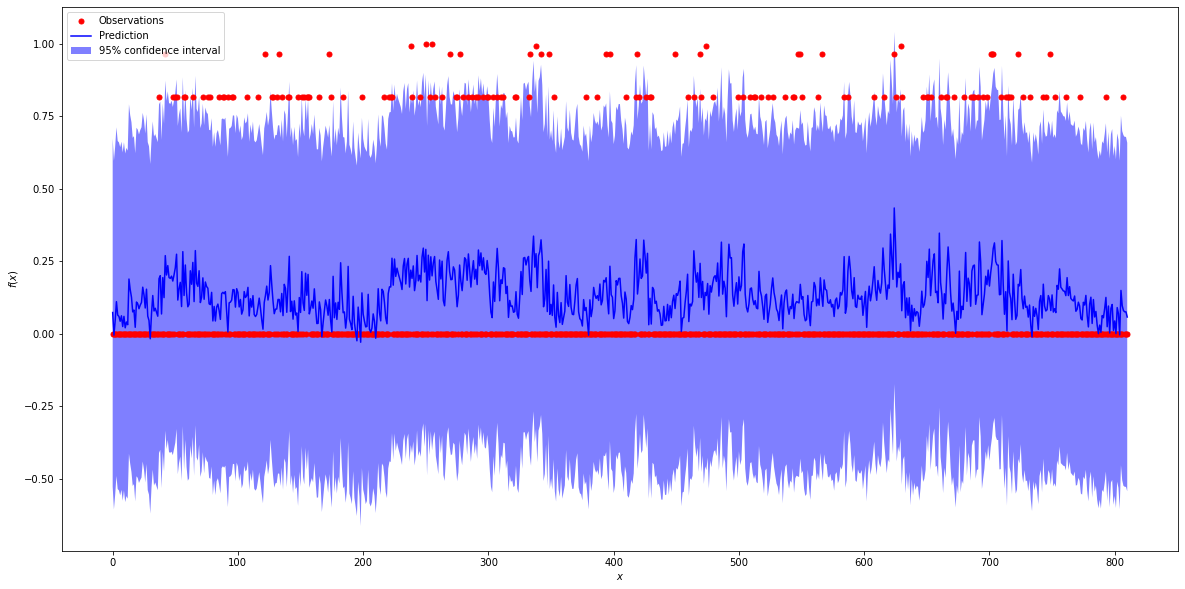

In [97]:
# fit the model
kernel = RBF(length_scale=1.0, length_scale_bounds = (1e-2, 1e2)) + \
    WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10)) + \
    RationalQuadratic()

'''
kernel: composition of kernels
random_state: determinisitc
n_restart_optizimer: how many restarts given the kernel testing
normalize: is the y variable normalized
'''
gp = GaussianProcessRegressor(kernel=kernel,random_state=2021, n_restarts_optimizer=6, normalize_y=True)
# fit the data
gp.fit(x_train, y_train)
# predict
y_pred, sigma = gp.predict(x_test, return_std=True)

print('best kernel found during restarts: ',gp.kernel_)
print('marginal likelehood: ',gp.log_marginal_likelihood_value_)
print('R2 score: ',gp.score(x_test,y_test))

'''
Plot observations vs prediction and confidence inteval
'''
fig = plt.figure(figsize = (20,10))

plt.plot(range(len(x_test)), y_test, 'r.' , markersize=10, label=u"Observations")
plt.plot(range(len(x_test)), y_pred, 'b-', label=u"Prediction")
plt.fill(np.concatenate([range(len(x_test)), range(len(x_test))[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc="b", ec='None', label="95% confidence interval")

plt.xlabel('$x$')
plt.ylabel("$f(x)$")
plt.legend(loc = 'upper left')
plt.show()

### Run Evaluation

In [98]:
# join predictions to test dataframe
test['y_pred'] = y_pred
# grab only geoids and prediction column
prediction_df = test[['geoid', 'y_pred']]
# extract values as lists
predictions = prediction_df.loc[:, 'y_pred'].values
geoids = prediction_df.loc[:, 'geoid'].values

'''
predicitons: array of y_pred
geoids: array of geoids
testing year
target_variable rank | count
how to handle ties
number of periods predicting 1+
evaluation index 1 or 2
'''
results, df = evaluator(predictions, geoids, int(test_years[0]), target_var = 'rank', ties = 'min', num_periods_predicted =1, eval_index = 1, simple=True)
results.head()

0.05275242961386106


,UC,LC
% targeted,,
5%,12.3,7
10%,21.4,19.3
15%,31.6,30.5
20%,41.2,40.1
